Marco de Luca   - ENSIIE ERASMUS-M2QF
Jacopo Spandri  - ENSIIE ERASMUS-M2QF


TP5 - MAL PROJECT

LOADING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    IsolationForest,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from scipy.stats import randint, uniform



DATA LOADING AND PREPROCESSING

In [2]:
df = pd.read_csv("celldata.csv")
print(df.head())
print(df.info())
print(df.describe())

print(df.describe().loc[["min", "max"]])
print(df.isnull().sum())

print(df["Geography"].unique())
print(df["Gender"].unique())

# define features and target
y = df["Churn"]
X = df.drop(columns=["Churn"])

# encoding categorical variables
X["Gender"] = X["Gender"].map({"Female": 0, "Male": 1})
X = pd.get_dummies(X, columns=["Geography"], drop_first=True)

print(X.head())
print(X.info())
print(y.value_counts())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          632   Germany  Female   50       5  107959.39              1   
1          649    France  Female   42       7       0.00              2   
2          595    France    Male   29       6  150685.79              1   
3          653     Spain    Male   35       6  116662.96              2   
4          559     Spain  Female   40       7  144470.77              1   

   HasCrCard  IsActiveMember  Salary  Churn  
0          1               1    6985      1  
1          0               1   22974      0  
2          1               0   87771      0  
3          1               1   23864      0  
4          1               1   18918      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-n

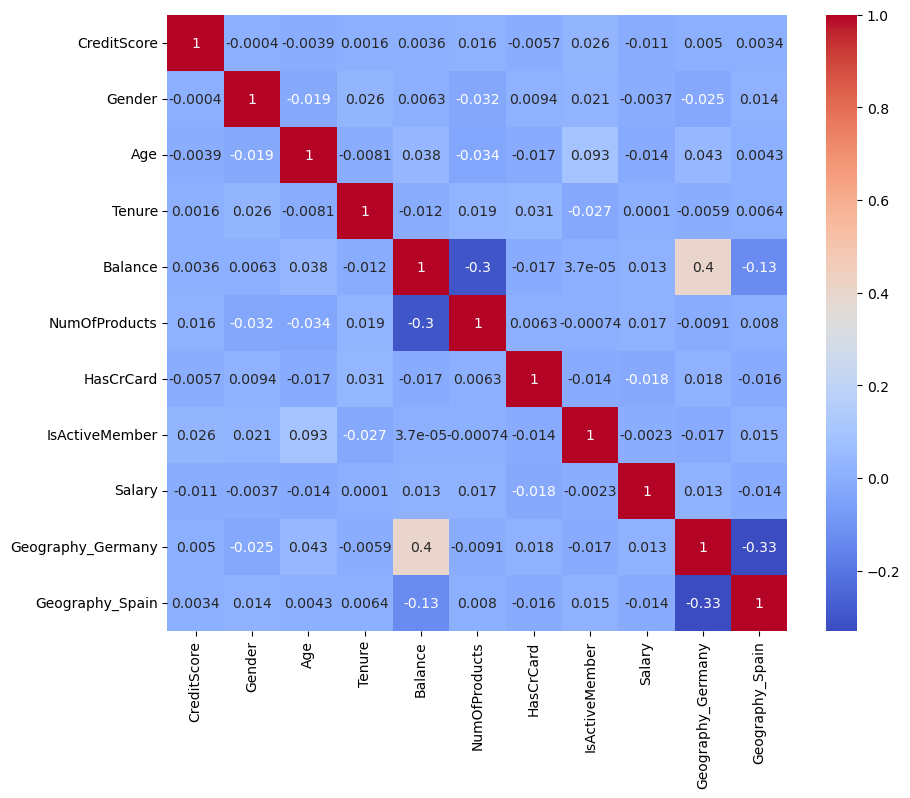

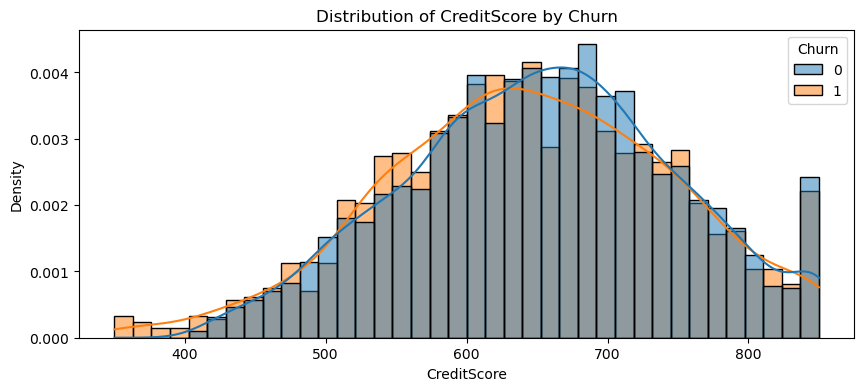

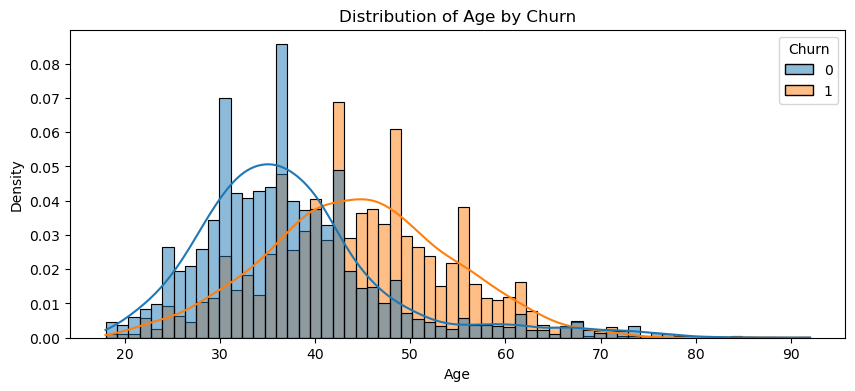

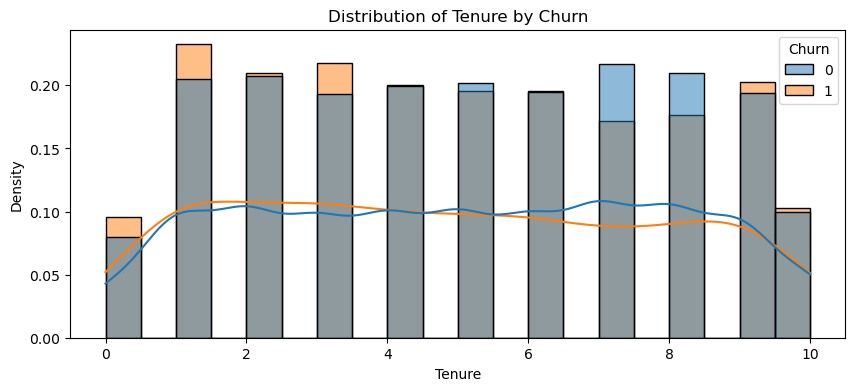

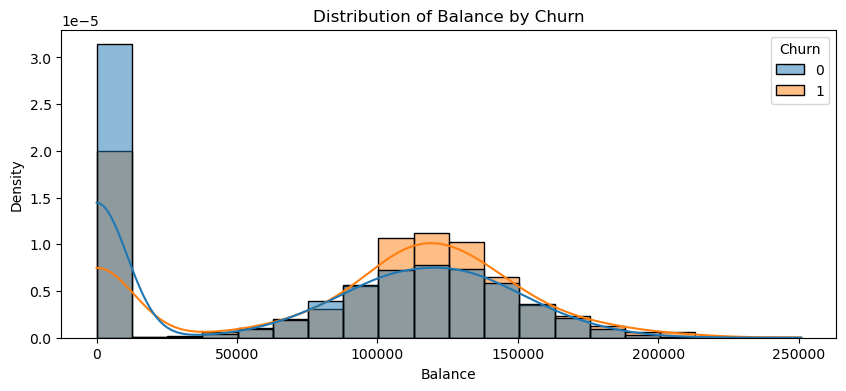

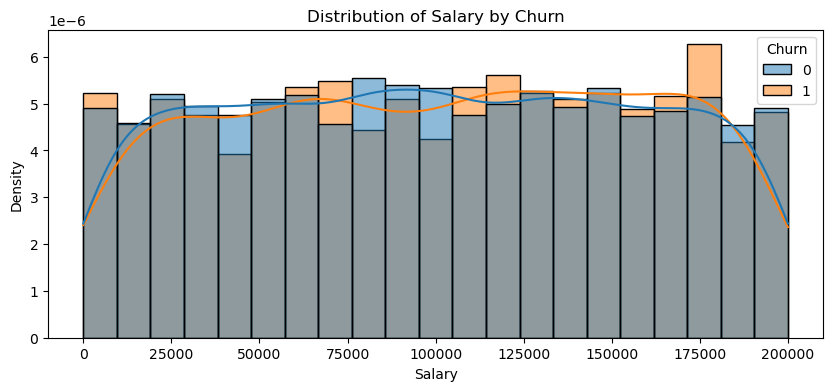

In [3]:
# correlation matrix
corr = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# distribution plots
for col in ["CreditScore", "Age", "Tenure", "Balance", "Salary"]:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=df,
        x=col,
        hue="Churn",
        kde=True,
        stat="density",
        common_norm=False,
    )
    plt.title(f"Distribution of {col} by Churn")
    plt.show()

Isolation Forest - % points marked as anomalies (top 5%): 2.50%
LOF - % points marked as anomalies: 2.50%

=== iso_anomaly ===
                 mean  count
iso_anomaly                 
0            0.189231   7800
1            0.665000    200

=== lof_anomaly ===
                 mean  count
lof_anomaly                 
0            0.190256   7800
1            0.625000    200


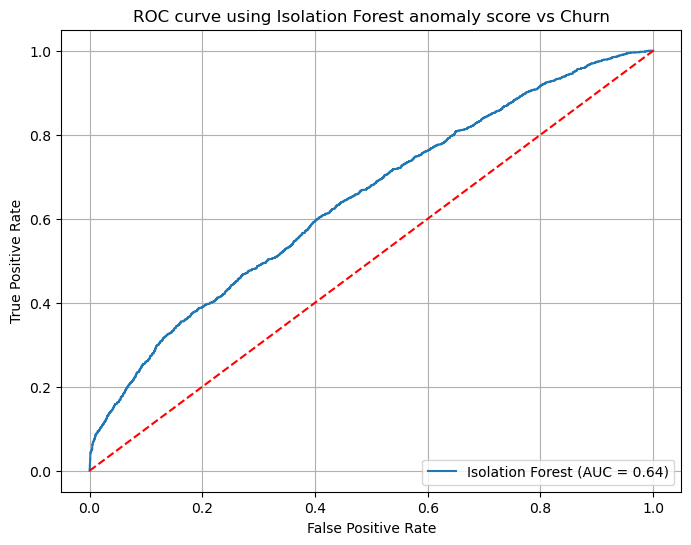

In [4]:
# =============================================================================
# 2. Unsupervised anomaly detection (Isolation Forest + LOF)
# =============================================================================

# We use all preprocessed features X (numeric Gender + Geography dummies)
# and standardize them for anomaly detection algorithms
scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X)

# %%
# === 1) Isolation Forest ===
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",  # let the model estimate the fraction of anomalies
    random_state=42,
)
iso.fit(X_anom_scaled)

# score_samples: lower values => more anomalous
iso_raw_scores = iso.score_samples(X_anom_scaled)
iso_scores = -iso_raw_scores  # invert the sign: higher = more anomalous

# Define anomalies as the top 5% most anomalous points (threshold can be tuned)
threshold_iso = np.percentile(iso_scores, 97.5)
iso_anomaly_flag = (iso_scores >= threshold_iso).astype(int)

print(
    f"Isolation Forest - % points marked as anomalies (top 5%): {iso_anomaly_flag.mean()*100:.2f}%"
)

# %%
# === 2) Local Outlier Factor (LOF) ===
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.025,  # ~5% expected anomalies
    novelty=False,  # classic mode: fit_predict on the entire dataset
)
lof_labels = lof.fit_predict(X_anom_scaled)  # -1 = outlier, 1 = inlier
lof_anomaly_flag = (lof_labels == -1).astype(int)

print(f"LOF - % points marked as anomalies: {lof_anomaly_flag.mean()*100:.2f}%")

# Add anomaly information to a copy of the original dataframe
df_anom = df.copy()
df_anom["iso_score"] = iso_scores
df_anom["iso_anomaly"] = iso_anomaly_flag
df_anom["lof_anomaly"] = lof_anomaly_flag

# %%
# Comparison of churn rate between anomalies and non-anomalies
for col in ["iso_anomaly", "lof_anomaly"]:
    print(f"\n=== {col} ===")
    print(df_anom.groupby(col)["Churn"].agg(["mean", "count"]))

# %%
# Isolation Forest: ROC curve using anomaly score vs Churn
fpr_iso, tpr_iso, _ = roc_curve(y, iso_scores)
roc_auc_iso = auc(fpr_iso, tpr_iso)

plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC = {roc_auc_iso:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve using Isolation Forest anomaly score vs Churn")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [5]:
# split into train and test with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features for models requiring it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# sample weights to handle class imbalance
classes = np.unique(y_train)
class_counts = np.bincount(y_train)
class_weights = {cls: len(y_train) / (len(classes) * class_counts[cls]) 
                 for cls in classes}
sample_weight = np.array([class_weights[y] for y in y_train])

MODELS FITTING


=== GaussianNB ===
Accuracy: 0.7344
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1278
           1       0.41      0.69      0.51       322

    accuracy                           0.73      1600
   macro avg       0.66      0.72      0.66      1600
weighted avg       0.80      0.73      0.76      1600

Confusion Matrix:
[[953 325]
 [100 222]]


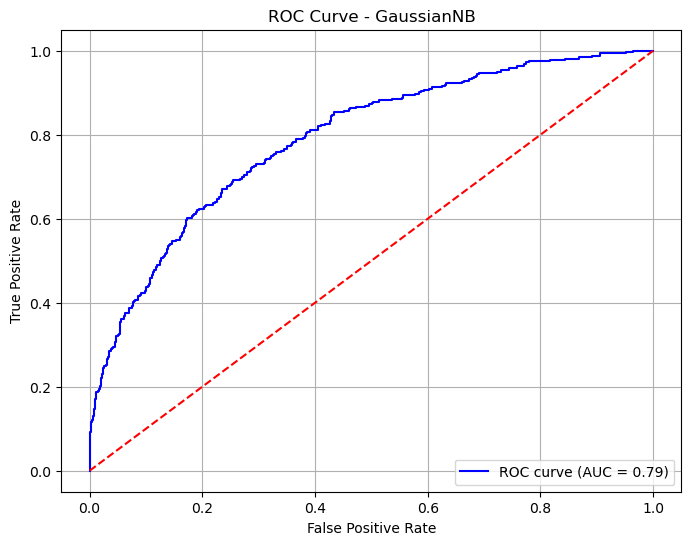


=== LDA ===
Accuracy: 0.8131
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1278
           1       0.61      0.20      0.30       322

    accuracy                           0.81      1600
   macro avg       0.72      0.58      0.60      1600
weighted avg       0.78      0.81      0.77      1600

Confusion Matrix:
[[1237   41]
 [ 258   64]]


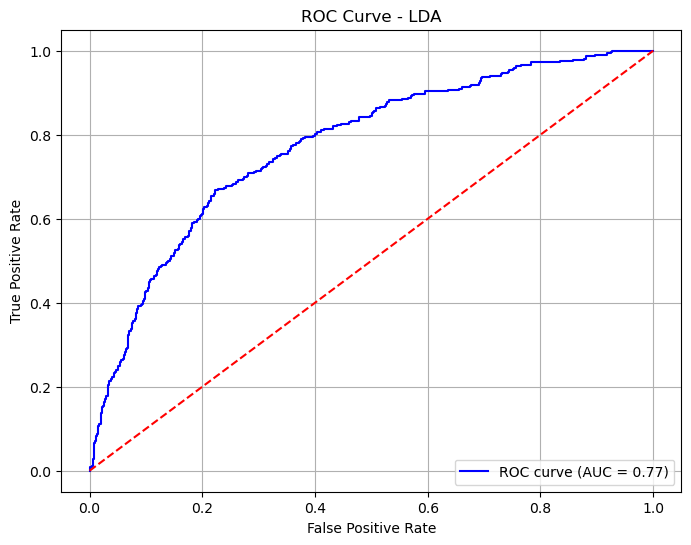


=== QDA ===
Accuracy: 0.8331
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1278
           1       0.66      0.35      0.46       322

    accuracy                           0.83      1600
   macro avg       0.76      0.65      0.68      1600
weighted avg       0.81      0.83      0.81      1600

Confusion Matrix:
[[1219   59]
 [ 208  114]]


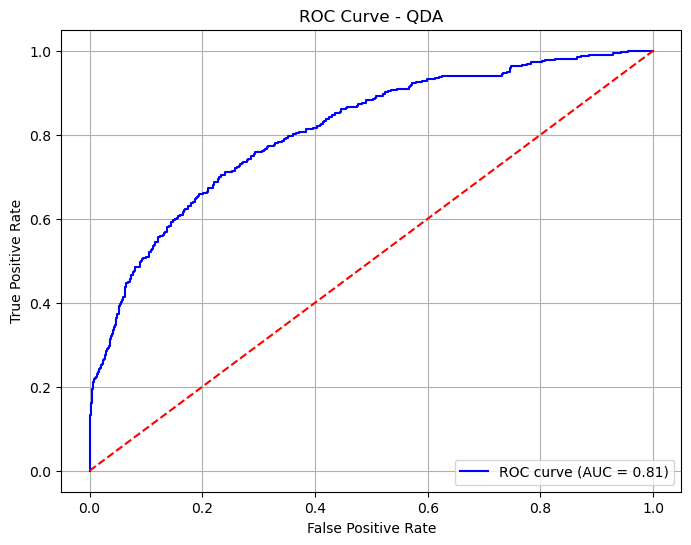


=== Logistic Regression ===
Accuracy: 0.7256
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1278
           1       0.40      0.70      0.51       322

    accuracy                           0.73      1600
   macro avg       0.65      0.72      0.66      1600
weighted avg       0.80      0.73      0.75      1600

Confusion Matrix:
[[935 343]
 [ 96 226]]


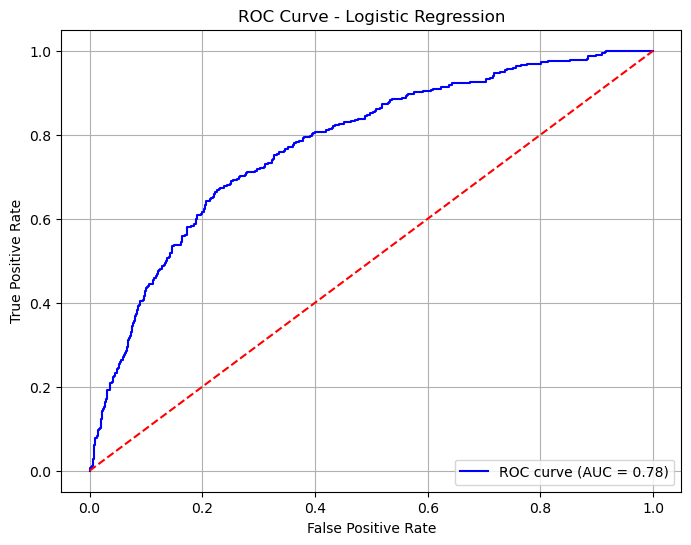


=== KNN ===
Accuracy: 0.8325
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1278
           1       0.65      0.37      0.47       322

    accuracy                           0.83      1600
   macro avg       0.75      0.66      0.69      1600
weighted avg       0.81      0.83      0.81      1600

Confusion Matrix:
[[1213   65]
 [ 203  119]]


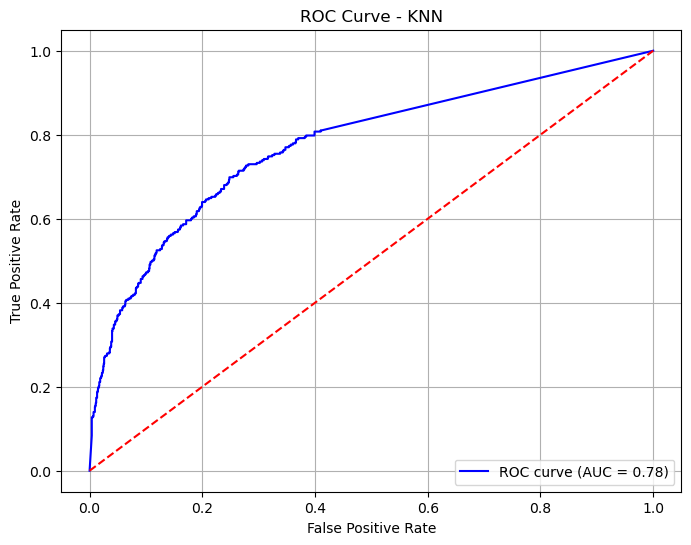


=== Decision Tree ===
Accuracy: 0.7844
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1278
           1       0.47      0.65      0.55       322

    accuracy                           0.78      1600
   macro avg       0.69      0.73      0.70      1600
weighted avg       0.82      0.78      0.80      1600

Confusion Matrix:
[[1046  232]
 [ 113  209]]


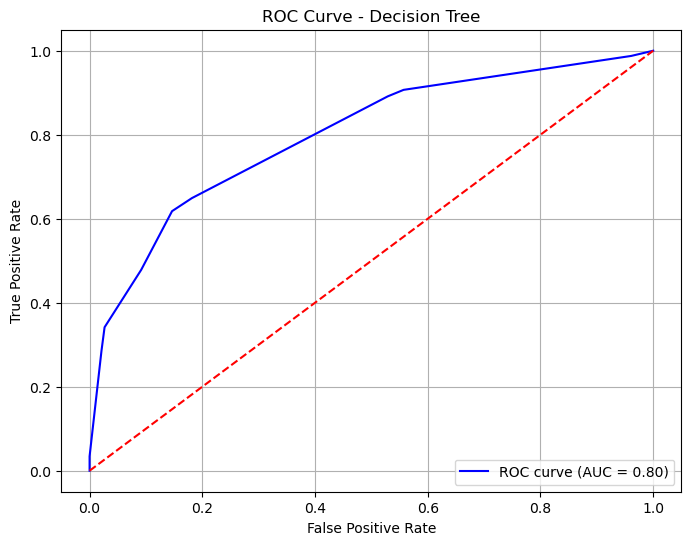


=== Bagging (Decision Trees) ===
Accuracy: 0.8531
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1278
           1       0.71      0.45      0.55       322

    accuracy                           0.85      1600
   macro avg       0.79      0.70      0.73      1600
weighted avg       0.84      0.85      0.84      1600

Confusion Matrix:
[[1220   58]
 [ 177  145]]


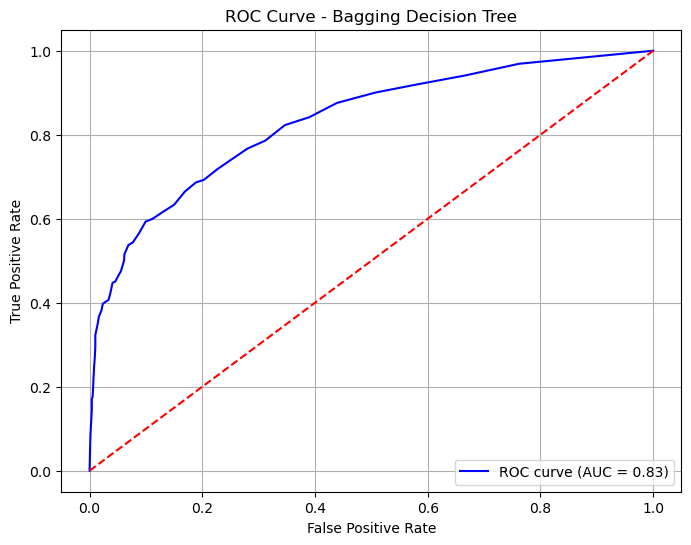


=== Random Forest ===
Accuracy: 0.8675
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1278
           1       0.81      0.45      0.58       322

    accuracy                           0.87      1600
   macro avg       0.84      0.71      0.75      1600
weighted avg       0.86      0.87      0.85      1600

Confusion Matrix:
[[1243   35]
 [ 177  145]]


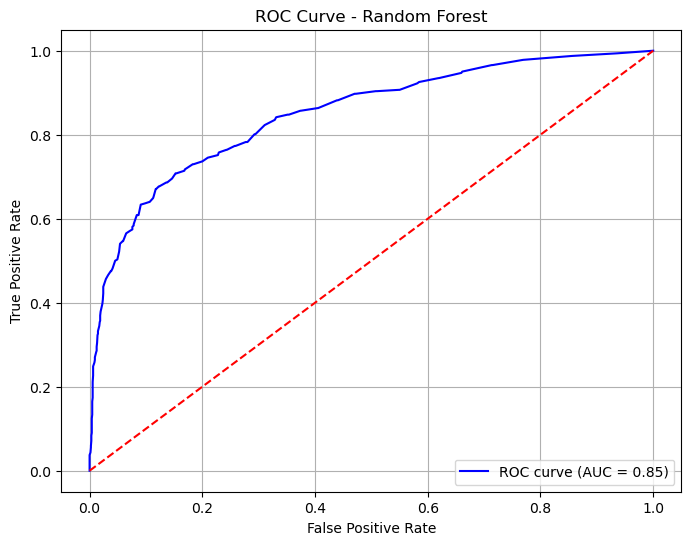


=== Extra Trees ===
Accuracy: 0.8612
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1278
           1       0.76      0.45      0.57       322

    accuracy                           0.86      1600
   macro avg       0.82      0.71      0.74      1600
weighted avg       0.85      0.86      0.85      1600

Confusion Matrix:
[[1232   46]
 [ 176  146]]


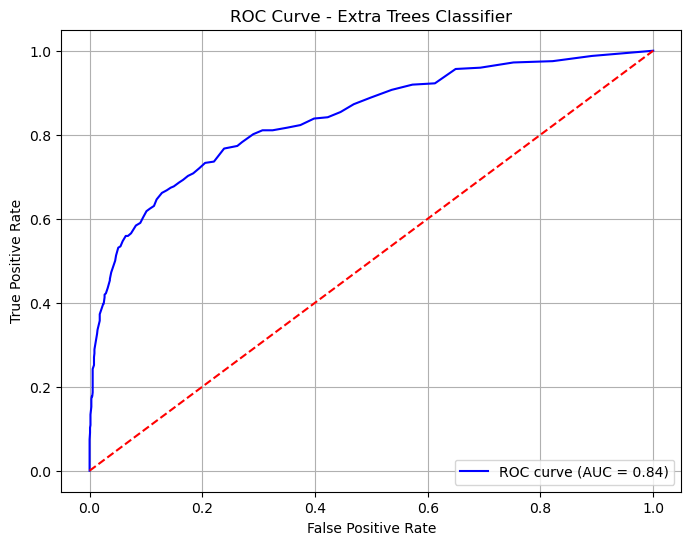


=== AdaBoost ===
Accuracy: 0.7875
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1278
           1       0.48      0.72      0.58       322

    accuracy                           0.79      1600
   macro avg       0.70      0.76      0.72      1600
weighted avg       0.83      0.79      0.80      1600

Confusion Matrix:
[[1028  250]
 [  90  232]]


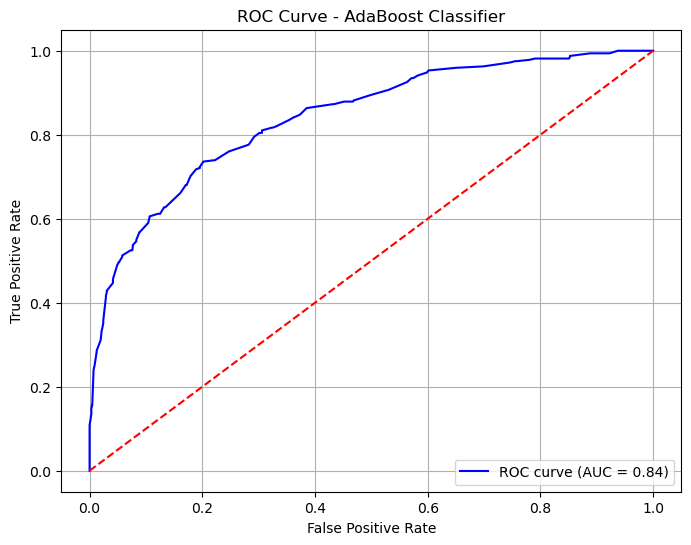


=== Gradient Boosting ===
Accuracy: 0.8056
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1278
           1       0.51      0.75      0.61       322

    accuracy                           0.81      1600
   macro avg       0.72      0.78      0.74      1600
weighted avg       0.84      0.81      0.82      1600

Confusion Matrix:
[[1048  230]
 [  81  241]]


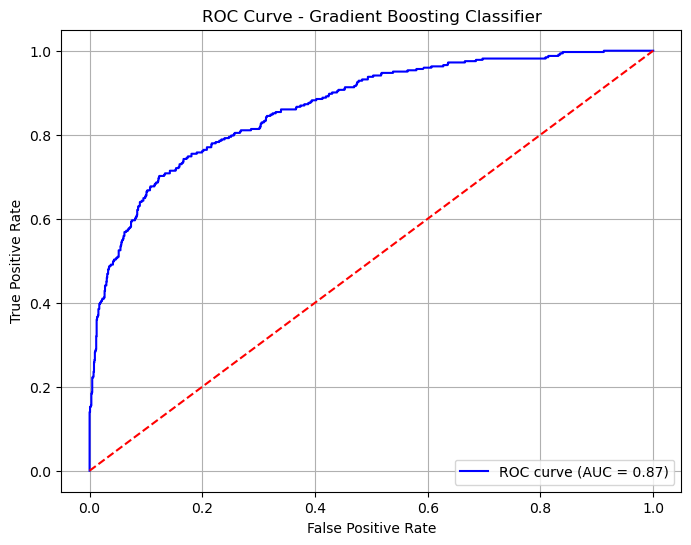


=== Robust Stacking Classifier ===
Accuracy: 0.8562
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1278
           1       0.68      0.55      0.61       322

    accuracy                           0.86      1600
   macro avg       0.78      0.74      0.76      1600
weighted avg       0.85      0.86      0.85      1600

Confusion Matrix:
[[1193   85]
 [ 145  177]]


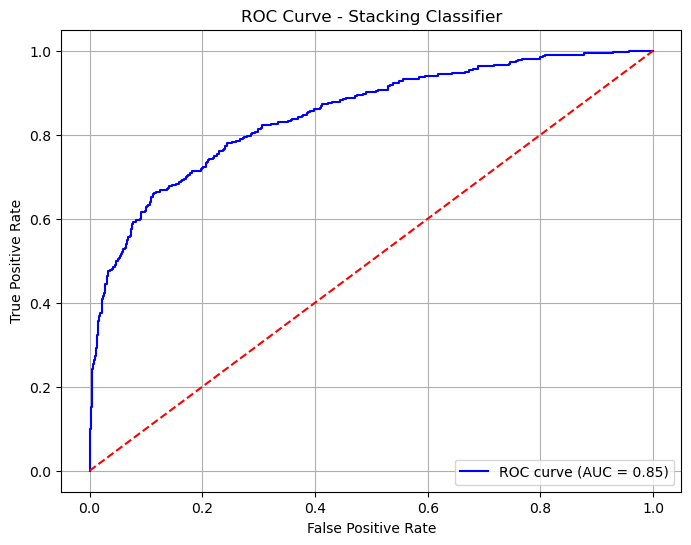

In [ ]:
# GAUSSIAN NAIVE BAYES
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train, sample_weight=sample_weight)
y_pred = gnb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\n=== GaussianNB ===")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

y_prob = gnb.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GaussianNB")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# LINEAR DISCRIMINANT ANALYSIS
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)

print("\n=== LDA ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lda):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LDA")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# QUARATIC DISCRIMINANT ANALYSIS
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)

print("\n=== QDA ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_qda):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_qda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

y_prob_qda = qda.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_qda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - QDA")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# LOGISTIC REGRESSION
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

print("\n=== Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# K-NEAREST NEIGHBORS
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("\n=== KNN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# DECISION TREE
dt = DecisionTreeClassifier(
    criterion="gini", max_depth=20, max_leaf_nodes=10, random_state=42, class_weight="balanced"
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n=== Decision Tree ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

y_prob_dt = dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# BAGGING (DECISION TREES)
bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion="gini", random_state=42, class_weight="balanced"),
    n_estimators=50,
    random_state=42,
)
bagging_dt.fit(X_train, y_train)
y_pred_bagging = bagging_dt.predict(X_test)

print("\n=== Bagging (Decision Trees) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bagging))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bagging))

y_prob_bagging = bagging_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bagging)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bagging Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# RANDOM FOREST
rf = RandomForestClassifier(criterion="gini", random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# EXTRA TREES
etf = ExtraTreesClassifier(criterion="gini", random_state=42, class_weight="balanced")
etf.fit(X_train, y_train)
y_pred_etf = etf.predict(X_test)

print("\n=== Extra Trees ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_etf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_etf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_etf))

y_prob_etf = etf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_etf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Extra Trees Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# ADABOOST 
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train, sample_weight=sample_weight)
y_pred_adb = adb.predict(X_test)

print("\n=== AdaBoost ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adb):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_adb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adb))

y_prob_adb = adb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# GRADIENT BOOSTING
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train, sample_weight=sample_weight)
y_pred_gbc = gbc.predict(X_test)

print("\n=== Gradient Boosting ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gbc):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

y_prob_gbc = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# STACKING
lr = LogisticRegression(class_weight="balanced")
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
gb = GradientBoostingClassifier(random_state=42)
nb = GaussianNB()
et = ExtraTreesClassifier(class_weight="balanced", random_state=42)

estimators = [
    ("lr", lr, "scaled"),  
    ("rf", rf, "raw"),     
    ("gb", gb, "raw"),     
    ("nb", nb, "scaled"),  
    ("et", et, "raw")      
]

meta_train = np.zeros((X_train.shape[0], len(estimators)))
meta_test = np.zeros((X_test.shape[0], len(estimators)))

for i, (name, model, data_type) in enumerate(estimators):
    X_tr = X_train_scaled if data_type == "scaled" else X_train
    X_te = X_test_scaled if data_type == "scaled" else X_test
    try:
        model.fit(X_tr, y_train, sample_weight=sample_weight)
    except TypeError:
        model.fit(X_tr, y_train)
    meta_train[:, i] = model.predict_proba(X_tr)[:, 1]
    meta_test[:, i] = model.predict_proba(X_te)[:, 1]

final_est = LogisticRegression(class_weight="balanced", max_iter=1000)
final_est.fit(meta_train, y_train, sample_weight=sample_weight)

y_pred_stack = final_est.predict(meta_test)
y_prob_stack = final_est.predict_proba(meta_test)[:, 1]

print("\n=== Robust Stacking Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_stack))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# Summary of all models' performance
models_info = [
    ("GaussianNB", gnb, X_test_scaled),
    ("LDA", lda, X_test_scaled),
    ("QDA", qda, X_test_scaled),
    ("Logistic Regression", logreg, X_test_scaled),
    ("KNN", knn, X_test_scaled),
    ("Decision Tree", dt, X_test),
    ("Bagging DT", bagging_dt, X_test),
    ("Random Forest", rf, X_test),
    ("Extra Trees", etf, X_test),
    ("AdaBoost", adb, X_test),
    ("Gradient Boosting", gbc, X_test),
    ("Stacking", (estimators, final_est), X_test_scaled),
]

results = []

for name, model, X_te in models_info:
    if isinstance(model, tuple):
        base_learners, meta_learner = model
        meta_features = np.zeros((X_te.shape[0], len(base_learners)))
        for i, (b_name, b_model, data_type) in enumerate(base_learners):
            X_input = X_test_scaled if data_type == "scaled" else X_test
            meta_features[:, i] = b_model.predict_proba(X_input)[:, 1]
        y_pred = meta_learner.predict(meta_features)
        y_prob = meta_learner.predict_proba(meta_features)[:, 1]
    else:
        y_pred = model.predict(X_te)
        y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
        }
    )

summary_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\n=== Test-set performance")
print(summary_df)



=== Test-set performance (single split) ===
                  Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
10    Gradient Boosting  0.805625   0.511677  0.748447  0.607818  0.866407
11             Stacking  0.856250   0.675573  0.549689  0.606164  0.847629
7         Random Forest  0.866250   0.803371  0.444099  0.572000  0.842699
9              AdaBoost  0.787500   0.481328  0.720497  0.577114  0.840651
8           Extra Trees  0.861250   0.760417  0.453416  0.568093  0.839796
6            Bagging DT  0.853125   0.714286  0.450311  0.552381  0.830793
2                   QDA  0.833125   0.658960  0.354037  0.460606  0.809060
5         Decision Tree  0.784375   0.473923  0.649068  0.547837  0.798274
0            GaussianNB  0.734375   0.405850  0.689441  0.510932  0.789707
3   Logistic Regression  0.725625   0.397188  0.701863  0.507295  0.776624
4                   KNN  0.832500   0.646739  0.369565  0.470356  0.776616
1                   LDA  0.813125   0.609524  0.198758 

In [18]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_models = [
    ("Decision Tree", dt),
    ("Bagging DT", bagging_dt),
    ("Random Forest", rf),
    ("Extra Trees", etf),
    ("AdaBoost", adb),
    ("Gradient Boosting", gbc)
]

cv_results = []

for name, model in cv_models:
    scores = cross_val_score(
        model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
    )
    cv_results.append(
        {
            "Model": name,
            "CV ROC-AUC mean": scores.mean(),
            "CV ROC-AUC std": scores.std(),
        }
    )

cv_df = pd.DataFrame(cv_results).sort_values(by="CV ROC-AUC mean", ascending=False)
print("\n=== Cross-validation performance (5-fold, training set) ===")
print(cv_df)



=== Cross-validation performance (5-fold, training set) ===
               Model  CV ROC-AUC mean  CV ROC-AUC std
5  Gradient Boosting         0.862315        0.011158
2      Random Forest         0.850366        0.009545
3        Extra Trees         0.842701        0.007115
4           AdaBoost         0.841124        0.010631
1         Bagging DT         0.838461        0.009011
0      Decision Tree         0.809786        0.012939


In [ ]:
# =============================================================================
# 7. Adding anomaly features and retraining models (optional analysis)
# =============================================================================

# 7.1 Add anomaly flags as features
X_enhanced = X.copy()
X_enhanced["iso_anomaly"] = iso_anomaly_flag
X_enhanced["lof_anomaly"] = lof_anomaly_flag

# 7.2 New train-test split with anomaly features
X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)


scaler_anom = StandardScaler()
X_train_anom_scaled = scaler_anom.fit_transform(X_train_anom)
X_test_anom_scaled = scaler_anom.transform(X_test_anom)

# 7.3 Retrain models with anomaly features (same structure as before)
gnb_anom = GaussianNB().fit(X_train_anom, y_train_anom)
lda_anom = LinearDiscriminantAnalysis().fit(X_train_anom, y_train_anom)
qda_anom = QuadraticDiscriminantAnalysis().fit(X_train_anom, y_train_anom)

logreg_anom = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg_anom.fit(X_train_anom_scaled, y_train_anom)

knn_anom = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn_anom.fit(X_train_anom_scaled, y_train_anom)

dt_anom = DecisionTreeClassifier(
    criterion="gini", max_depth=20, max_leaf_nodes=10, random_state=42
).fit(X_train_anom, y_train_anom)

bagging_dt_anom = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion="gini", random_state=42),
    n_estimators=50,
    random_state=42,
).fit(X_train_anom, y_train_anom)

rf_anom = RandomForestClassifier(criterion="gini", random_state=42).fit(
    X_train_anom, y_train_anom
)
etf_anom = ExtraTreesClassifier(criterion="gini", random_state=42).fit(
    X_train_anom, y_train_anom
)
adb_anom = AdaBoostClassifier(n_estimators=100, random_state=42).fit(
    X_train_anom, y_train_anom
)
gbc_anom = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(
    X_train_anom, y_train_anom
)

base_learners_anom = [
    ("gnb", GaussianNB()),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis()),
    (
        "lr",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("lr_model", LogisticRegression(max_iter=1000, class_weight="balanced")),
            ]
        ),
    ),
    ("dt", DecisionTreeClassifier(max_depth=5, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("ab", AdaBoostClassifier(n_estimators=100, random_state=42)),
    (
        "knn",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("knn_model", KNeighborsClassifier(n_neighbors=5, weights="distance")),
            ]
        ),
    ),
]

meta_learner_anom = LogisticRegression(max_iter=1000)

stack_model_anom = StackingClassifier(
    estimators=base_learners_anom,
    final_estimator=meta_learner_anom,
    cv=None,
).fit(X_train_anom, y_train_anom)

models_info_anom = [
    ("GaussianNB", gnb_anom, X_test_anom),
    ("LDA", lda_anom, X_test_anom),
    ("QDA", qda_anom, X_test_anom),
    ("Logistic Regression", logreg_anom, X_test_anom_scaled),
    ("KNN", knn_anom, X_test_anom_scaled),
    ("Decision Tree", dt_anom, X_test_anom),
    ("Bagging DT", bagging_dt_anom, X_test_anom),
    ("Random Forest", rf_anom, X_test_anom),
    ("Extra Trees", etf_anom, X_test_anom),
    ("AdaBoost", adb_anom, X_test_anom),
    ("Gradient Boosting", gbc_anom, X_test_anom),
    ("Stacking", stack_model_anom, X_test_anom),
]

results_anom = []

for name, model, X_te in models_info_anom:
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test_anom, y_prob)
    else:
        roc_auc = None

    acc = accuracy_score(y_test_anom, y_pred)
    prec = precision_score(y_test_anom, y_pred)
    rec = recall_score(y_test_anom, y_pred)
    f1 = f1_score(y_test_anom, y_pred)

    results_anom.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
        }
    )

summary_df_anom = pd.DataFrame(results_anom).sort_values(
    by="ROC-AUC", ascending=False
)
print("\n=== Performance with anomaly features ===")
print(summary_df_anom)

# Compare base vs anomaly-augmented models
try:
    comparison_df = summary_df.merge(
        summary_df_anom, on="Model", suffixes=("_base", "_anom")
    )
    print("\n=== Comparison base vs with anomalies ===")
    print(comparison_df)
except NameError:
    print(
        "summary_df (base) is not defined in this kernel: run the cell that calculates it first."
    )


=== Performance with anomaly features ===
                  Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
10    Gradient Boosting  0.869375   0.789744  0.478261  0.595745  0.867508
11             Stacking  0.868125   0.768116  0.493789  0.601134  0.862963
7         Random Forest  0.868750   0.791667  0.472050  0.591440  0.843711
9              AdaBoost  0.856875   0.733668  0.453416  0.560461  0.840706
6            Bagging DT  0.857500   0.713636  0.487578  0.579336  0.833699
8           Extra Trees  0.859375   0.753927  0.447205  0.561404  0.833388
2                   QDA  0.816875   0.674699  0.173913  0.276543  0.815273
5         Decision Tree  0.856875   0.736041  0.450311  0.558767  0.810419
3   Logistic Regression  0.737500   0.409594  0.689441  0.513889  0.800404
1                   LDA  0.820625   0.669903  0.214286  0.324706  0.797403
4                   KNN  0.831875   0.629268  0.400621  0.489564  0.783193
0            GaussianNB  0.792500   0.391304  0.055901  0

LogisticRegression best params: {'C': 1}
RandomForest best params: {'max_depth': None, 'n_estimators': 200}
GradientBoosting best params: {'max_depth': 3, 'n_estimators': 100}
GaussianNB fitted directly (no hyperparams)
ExtraTrees best params: {'max_depth': None, 'n_estimators': 200}

=== Stacking Classifier ===
Accuracy: 0.8581
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1278
           1       0.68      0.56      0.61       322

    accuracy                           0.86      1600
   macro avg       0.79      0.75      0.76      1600
weighted avg       0.85      0.86      0.85      1600

Confusion Matrix:
[[1193   85]
 [ 142  180]]


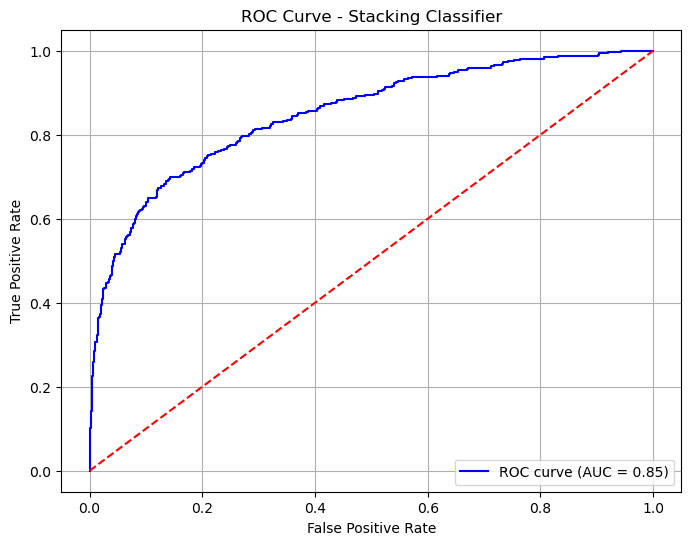

In [20]:
# =============================================================================
# STACKING CLASSIFIER WITH CV HYPERPARAMETER TUNING
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# ------------------------
# 1️⃣ Define base learners & hyperparameter grids
# ------------------------
base_learners_params = {
    "LogisticRegression": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000),
        "params": {"C": [0.1, 1, 10]},  # example grid
        "data": "scaled"
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 5, 10]},
        "data": "raw"
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 5]},
        "data": "raw"
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": None,
        "data": "scaled"
    },
    "ExtraTrees": {
        "model": ExtraTreesClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 5, 10]},
        "data": "raw"
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------
# 2️⃣ Fit base learners with CV hyperparameter tuning (if grid exists)
# ------------------------
best_base_learners = {}

for name, info in base_learners_params.items():
    model = info["model"]
    param_grid = info["params"]
    X_data = X_train_scaled if info["data"] == "scaled" else X_train

    if param_grid:
        gs = GridSearchCV(model, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
        try:
            gs.fit(X_data, y_train, sample_weight=sample_weight)
        except TypeError:
            gs.fit(X_data, y_train)
        best_model = gs.best_estimator_
        # Fit best model on full training set
        try:
            best_model.fit(X_data, y_train, sample_weight=sample_weight)
        except TypeError:
            best_model.fit(X_data, y_train)
        print(f"{name} best params: {gs.best_params_}")
    else:
        try:
            model.fit(X_data, y_train, sample_weight=sample_weight)
        except TypeError:
            model.fit(X_data, y_train)
        best_model = model
        print(f"{name} fitted directly (no hyperparams)")

    best_base_learners[name] = (best_model, info["data"])

# ------------------------
# 3️⃣ Generate meta-features
# ------------------------
meta_train = np.zeros((X_train.shape[0], len(best_base_learners)))
meta_test = np.zeros((X_test.shape[0], len(best_base_learners)))

for i, (name, (model, data_type)) in enumerate(best_base_learners.items()):
    X_tr = X_train_scaled if data_type == "scaled" else X_train
    X_te = X_test_scaled if data_type == "scaled" else X_test
    meta_train[:, i] = model.predict_proba(X_tr)[:, 1]
    meta_test[:, i] = model.predict_proba(X_te)[:, 1]

# ------------------------
# 4️⃣ Fit meta-learner
# ------------------------
final_est = LogisticRegression(class_weight="balanced", max_iter=1000)
try:
    final_est.fit(meta_train, y_train, sample_weight=sample_weight)
except TypeError:
    final_est.fit(meta_train, y_train)

# ------------------------
# 5️⃣ Predictions & Evaluation
# ------------------------
y_pred_stack = final_est.predict(meta_test)
y_prob_stack = final_est.predict_proba(meta_test)[:, 1]

print("\n=== Stacking Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_stack))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# =============================================================================
# 8. Hyperparameter tuning for key models (with internal 5-fold CV)
# =============================================================================

# Note: RandomizedSearchCV below uses 5-fold CV with ROC-AUC as the scoring metric.
# We tune: Gradient Boosting, Random Forest, AdaBoost, Extra Trees, Stacking.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 8.1 Gradient Boosting tuning
gb = GradientBoostingClassifier(random_state=42)

param_dist_gb = {
    "n_estimators": randint(50, 301),          # number of boosting stages
    "learning_rate": uniform(0.01, 0.19),      # shrinkage rate [0.01, 0.20]
    "max_depth": randint(2, 6),                # depth of individual trees
    "subsample": uniform(0.6, 0.4),            # subsampling fraction [0.6, 1.0]
    "min_samples_split": randint(2, 11),       # min samples to split an internal node
    "min_samples_leaf": randint(1, 11),        # min samples at a leaf
}

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

gb_search.fit(X_train, y_train)

print("\n=== Best Gradient Boosting params ===")
print(gb_search.best_params_)
print("Best CV ROC-AUC:", gb_search.best_score_)

gb_best = gb_search.best_estimator_
y_prob_gb_best = gb_best.predict_proba(X_test)[:, 1]
y_pred_gb_best = gb_best.predict(X_test)

print("\n=== Gradient Boosting tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_best))
print("Precision:", precision_score(y_test, y_pred_gb_best))
print("Recall:", recall_score(y_test, y_pred_gb_best))
print("F1-score:", f1_score(y_test, y_pred_gb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb_best))


# 8.2 Random Forest tuning
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist_rf = {
    "n_estimators": randint(100, 401),         # number of trees
    "max_depth": [None] + list(range(3, 11)),  # tree depth
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 21),
    "max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

rf_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

rf_search.fit(X_train, y_train)

print("\n=== Best Random Forest params ===")
print(rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

rf_best = rf_search.best_estimator_
y_prob_rf_best = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf_best = rf_best.predict(X_test)

print("\n=== Random Forest tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_best))
print("Precision:", precision_score(y_test, y_pred_rf_best))
print("Recall:", precision_score(y_test, y_pred_rf_best))
print("F1-score:", f1_score(y_test, y_pred_rf_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_best))


# 8.3 AdaBoost tuning
adb_tune = AdaBoostClassifier(random_state=42)

param_dist_adb = {
    "n_estimators": randint(50, 301),          # number of weak learners
    "learning_rate": uniform(0.01, 0.99),      # step size [0.01, 1.0]
}

adb_search = RandomizedSearchCV(
    estimator=adb_tune,
    param_distributions=param_dist_adb,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

adb_search.fit(X_train, y_train)

print("\n=== Best AdaBoost params ===")
print(adb_search.best_params_)
print("Best CV ROC-AUC:", adb_search.best_score_)

adb_best = adb_search.best_estimator_
y_prob_adb_best = adb_best.predict_proba(X_test)[:, 1]
y_pred_adb_best = adb_best.predict(X_test)

print("\n=== AdaBoost tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_adb_best))
print("Precision:", precision_score(y_test, y_pred_adb_best))
print("Recall:", recall_score(y_test, y_pred_adb_best))
print("F1-score:", f1_score(y_test, y_pred_adb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_adb_best))


# 8.4 Extra Trees tuning
et_tune = ExtraTreesClassifier(random_state=42, n_jobs=-1)

param_dist_et = {
    "n_estimators": randint(100, 401),
    "max_depth": [None] + list(range(3, 11)),
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 21),
    "max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "bootstrap": [True, False],
}

et_search = RandomizedSearchCV(
    estimator=et_tune,
    param_distributions=param_dist_et,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

et_search.fit(X_train, y_train)

print("\n=== Best Extra Trees params ===")
print(et_search.best_params_)
print("Best CV ROC-AUC:", et_search.best_score_)

et_best = et_search.best_estimator_
y_prob_et_best = et_best.predict_proba(X_test)[:, 1]
y_pred_et_best = et_best.predict(X_test)

print("\n=== Extra Trees tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_et_best))
print("Precision:", precision_score(y_test, y_pred_et_best))
print("Recall:", recall_score(y_test, y_pred_et_best))
print("F1-score:", f1_score(y_test, y_pred_et_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_et_best))


# 8.5 Stacking Classifier tuning
# We reuse the same base_learners defined earlier and tune only the meta-learner (logistic regression).
meta_learner_tune = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",      # supports L1 and L2 penalty
)

stack_base_learners = base_learners  # reuse your previous list

stack_clf = StackingClassifier(
    estimators=stack_base_learners,
    final_estimator=meta_learner_tune,
    cv=None,                 # no internal CV; RandomizedSearchCV handles CV outside
    n_jobs=-1
)

param_dist_stack = {
    "final_estimator__C": uniform(0.01, 9.99),    # regularization strength
    "final_estimator__penalty": ["l1", "l2"],     # type of penalty
}

stack_search = RandomizedSearchCV(
    estimator=stack_clf,
    param_distributions=param_dist_stack,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

stack_search.fit(X_train, y_train)

print("\n=== Best Stacking params ===")
print(stack_search.best_params_)
print("Best CV ROC-AUC:", stack_search.best_score_)

stack_best = stack_search.best_estimator_
y_prob_stack_best = stack_best.predict_proba(X_test)[:, 1]
y_pred_stack_best = stack_best.predict(X_test)

print("\n=== Stacking tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_stack_best))
print("Precision:", precision_score(y_test, y_pred_stack_best))
print("Recall:", recall_score(y_test, y_pred_stack_best))
print("F1-score:", f1_score(y_test, y_pred_stack_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_stack_best))


Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Gradient Boosting params ===
{'learning_rate': np.float64(0.028995234005420548), 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 149, 'subsample': np.float64(0.6571467271687763)}
Best CV ROC-AUC: 0.8650538479448905

=== Gradient Boosting tuned - Test metrics ===
Accuracy: 0.868125
Precision: 0.7905759162303665
Recall: 0.468944099378882
F1-score: 0.5886939571150097
ROC-AUC: 0.8651692765287377
Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Random Forest params ===
{'class_weight': 'balanced_subsample', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 151}
Best CV ROC-AUC: 0.861565276910157

=== Random Forest tuned - Test metrics ===
Accuracy: 0.825625
Precision: 0.5530864197530864
Recall: 0.5530864197530864
F1-score: 0.6162310866574966
ROC-AUC: 0.8577163463875037
Fitting 5 folds for each of 40 candidates, total

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = gbc.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold for F1: {best_threshold}")

# Apply new threshold
y_pred_new = (y_scores >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_new))

Best Threshold for F1: 0.272625173245248
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1278
           1       0.62      0.68      0.65       322

    accuracy                           0.85      1600
   macro avg       0.77      0.79      0.78      1600
weighted avg       0.86      0.85      0.86      1600



In [21]:
print("\n" + "="*80)
print("FAIRNESS ANALYSIS (SENSITIVE VARIABLE: GENDER)")
print("="*80)

# 1. Preparation of data for fairness analysis
# We use the Random Forest model ('rf') trained in section 4.8
# Create a temporary DataFrame with features, true target, and prediction
df_fairness = X_test.copy()
df_fairness['y_true'] = y_test
df_fairness['y_pred'] = gbc.predict(X_test)

# Mapping for readability (in your script: Female=0, Male=1)
gender_map = {0: 'Female', 1: 'Male'}
df_fairness['Gender_Label'] = df_fairness['Gender'].map(gender_map)

# Create masks for groups
mask_female = df_fairness['Gender'] == 0
mask_male = df_fairness['Gender'] == 1

print(f"Total samples in test set: {len(df_fairness)}")
print(f"Samples Female: {mask_female.sum()}")
print(f"Samples Male:   {mask_male.sum()}\n")

# -----------------------------------------------------------------------------
# CRITERION 1: INDEPENDENCE (Demographic Parity)
# Definition: P(Y_hat = 1 | A = Female) vs P(Y_hat = 1 | A = Male)
# The rate of positive prediction should be similar across groups.
# -----------------------------------------------------------------------------
prob_pred_churn_female = df_fairness.loc[mask_female, 'y_pred'].mean()
prob_pred_churn_male = df_fairness.loc[mask_male, 'y_pred'].mean()

print("--- 1. INDEPENDENCE ---")
print(f"Probability of predicting Churn (Female): {prob_pred_churn_female:.4f}")
print(f"Probability of predicting Churn (Male):   {prob_pred_churn_male:.4f}")
print(f"Gap (Female - Male): {prob_pred_churn_female - prob_pred_churn_male:.4f}")
if abs(prob_pred_churn_female - prob_pred_churn_male) > 0.1:
    print(">> WARNING: Possible violation of Independence (Disparate Impact).")
else:
    print(">> Independence substantially respected.")
print("-" * 40 + "\n")

# -----------------------------------------------------------------------------
# CRITERION 2: SEPARATION (Equalized Odds)
# Definition: P(Y_hat=1 | Y=y, A=Female) = P(Y_hat=1 | Y=y, A=Male)
# We compare TPR (Recall) and FPR between the two groups.
# -----------------------------------------------------------------------------
from sklearn.metrics import confusion_matrix

# Calculate metrics for Female
tn_f, fp_f, fn_f, tp_f = confusion_matrix(df_fairness.loc[mask_female, 'y_true'], 
                                          df_fairness.loc[mask_female, 'y_pred'], labels=[0,1]).ravel()
tpr_female = tp_f / (tp_f + fn_f) if (tp_f + fn_f) > 0 else 0
fpr_female = fp_f / (fp_f + tn_f) if (fp_f + tn_f) > 0 else 0

# Calculate metrics for Male
tn_m, fp_m, fn_m, tp_m = confusion_matrix(df_fairness.loc[mask_male, 'y_true'], 
                                          df_fairness.loc[mask_male, 'y_pred'], labels=[0,1]).ravel()
tpr_male = tp_m / (tp_m + fn_m) if (tp_m + fn_m) > 0 else 0
fpr_male = fp_m / (fp_m + tn_m) if (fp_m + tn_m) > 0 else 0

print("--- 2. SEPARATION ---")
print(f"True Positive Rate (TPR) Female: {tpr_female:.4f}")
print(f"True Positive Rate (TPR) Male:   {tpr_male:.4f}")
print(f"Diff TPR: {tpr_female - tpr_male:.4f}")
print("...")
print(f"False Positive Rate (FPR) Female: {fpr_female:.4f}")
print(f"False Positive Rate (FPR) Male:   {fpr_male:.4f}")
print(f"Diff FPR: {fpr_female - fpr_male:.4f}")
print("-" * 40 + "\n")

# -----------------------------------------------------------------------------
# CRITERION 3: SUFFICIENCY (Predictive Parity)
# Definition: P(Y=1 | Y_hat=1, A=Female) = P(Y=1 | Y_hat=1, A=Male)
# We compare Precision (Positive Predictive Value) between the groups.
# -----------------------------------------------------------------------------
from sklearn.metrics import precision_score

ppv_female = precision_score(df_fairness.loc[mask_female, 'y_true'], 
                             df_fairness.loc[mask_female, 'y_pred'], zero_division=0)
ppv_male = precision_score(df_fairness.loc[mask_male, 'y_true'], 
                           df_fairness.loc[mask_male, 'y_pred'], zero_division=0)

print("--- 3. SUFFICIENCY ---")
print(f"Precision (PPV) Female: {ppv_female:.4f}")
print(f"Precision (PPV) Male:   {ppv_male:.4f}")
print(f"Diff PPV: {ppv_female - ppv_male:.4f}")

if abs(ppv_female - ppv_male) > 0.1:
    print(">> WARNING: Model confidence varies significantly between genders.")
else:
    print(">> Sufficiency substantially respected (similar calibration).")
print("="*80)


FAIRNESS ANALYSIS (SENSITIVE VARIABLE: GENDER)
Total samples in test set: 1600
Samples Female: 733
Samples Male:   867

--- 1. INDEPENDENCE ---
Probability of predicting Churn (Female): 0.3724
Probability of predicting Churn (Male):   0.2284
Gap (Female - Male): 0.1441
>> WARNING: Possible violation of Independence (Disparate Impact).
----------------------------------------

--- 2. SEPARATION ---
True Positive Rate (TPR) Female: 0.7594
True Positive Rate (TPR) Male:   0.7333
Diff TPR: 0.0260
...
False Positive Rate (FPR) Female: 0.2399
False Positive Rate (FPR) Male:   0.1352
Diff FPR: 0.1047
----------------------------------------

--- 3. SUFFICIENCY ---
Precision (PPV) Female: 0.5201
Precision (PPV) Male:   0.5000
Diff PPV: 0.0201
>> Sufficiency substantially respected (similar calibration).
